<a href="https://colab.research.google.com/github/ProudPP/ProudPP.github.io/blob/main/tryoutSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas openpyxl pythainlp matplotlib
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 44.1 MB/s eta 0:00:00


In [6]:
# Step 1: Import required libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from pythainlp.tokenize import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential


In [7]:
responses_file = "/content/drive/MyDrive/วิทยานิพนธ์-พีรยา/practice/ตอบกลับ-แบบสอบถามสุขภาวะด้านอาชีพของครู.xlsx"
responses = pd.read_excel(responses_file)

lexicon_file = "/content/drive/MyDrive/วิทยานิพนธ์-พีรยา/practice/thai_word-sentiment.xlsx"
thai_lexicon = pd.read_excel(lexicon_file)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/วิทยานิพนธ์-พีรยา/practice/ตอบกลับ-แบบสอบถามสุขภาวะด้านอาชีพของครู.xlsx'

คิด sentiment เป็นสัดส่วน จำแนกตาม ประสบการณ์สอน

จำนวนครูในแต่ละกลุ่มประสบการณ์:
  experience_group  teacher_count
0              1-5             24
1             6-10             16
3            11-15              3
4            16-20              3
2              21+              7


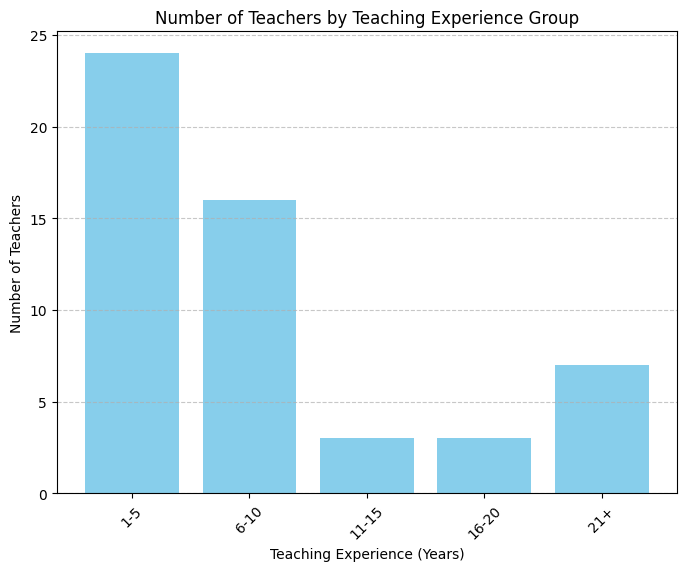

In [ ]:
# 1. **จำแนกครูตามประสบการณ์สอน**
bins = [0, 5, 10, 15, 20, float('inf')]
labels = ['1-5', '6-10', '11-15', '16-20', '21+']
responses['experience_group'] = pd.cut(responses['teach_years'], bins=bins, labels=labels, ordered=True)

# 2. **แสดงจำนวนครูตามกลุ่มที่จำแนก**
teacher_count = responses['experience_group'].value_counts().reset_index()
teacher_count.columns = ['experience_group', 'teacher_count']

# Sort the data by the order of experience groups
teacher_count = teacher_count.sort_values(by='experience_group')

# 3. **แสดงผลจำนวนครูตามกลุ่ม**
print("จำนวนครูในแต่ละกลุ่มประสบการณ์:")
print(teacher_count)

# 4. **สร้างกราฟ**
plt.figure(figsize=(8, 6))
plt.bar(teacher_count['experience_group'], teacher_count['teacher_count'], color='skyblue')
plt.title("Number of Teachers by Teaching Experience Group")
plt.xlabel("Teaching Experience (Years)")
plt.ylabel("Number of Teachers")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<ipython-input-19-c47c38788da7>:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sentiment_by_experience = cap_reason_sentiment.groupby(['experience_group', 'sentiment']).size().reset_index(name='count')


สัดส่วน Sentiment Analysis จำแนกตามกลุ่มประสบการณ์สอน:
sentiment         neg  pos
experience_group          
1-5               0.2  0.8
6-10              0.2  0.8
11-15             0.0  1.0
16-20             0.0  1.0
21+               0.0  1.0


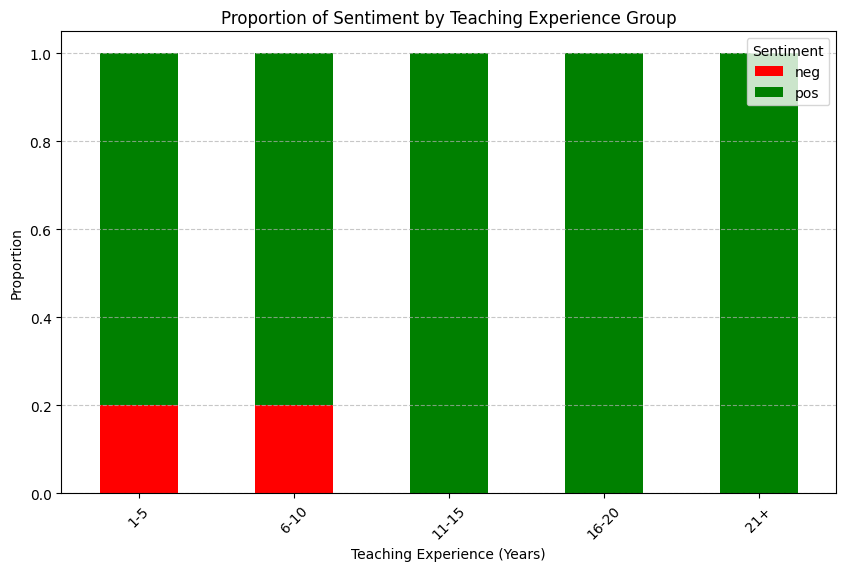

In [ ]:
# **วิเคราะห์ SA (Sentiment Analysis) จำแนกตามกลุ่มครู**
# เตรียมข้อมูลเฉพาะ experience_group และ cap_reason
cap_reason_data = responses[['experience_group', 'cap_reason']].dropna()

# ฟังก์ชันแบ่งคำ
def tokenize_text(text):
    tokens = word_tokenize(text, keep_whitespace=False)
    return tokens

# แบ่งคำใน cap_reason และสร้างตารางคำ
cap_reason_data['tokens'] = cap_reason_data['cap_reason'].apply(tokenize_text)
cap_reason_tokens = cap_reason_data.explode('tokens').reset_index(drop=True)
cap_reason_tokens['word'] = cap_reason_tokens['tokens'].str.strip().str.lower()

# จับคู่คำกับ sentiment lexicon
cap_reason_sentiment = cap_reason_tokens.merge(thai_lexicon, left_on='word', right_on='word', how='inner')

# คำนวณ Sentiment แยกตาม experience_group
sentiment_by_experience = cap_reason_sentiment.groupby(['experience_group', 'sentiment']).size().reset_index(name='count')

# Pivot Table เพื่อแสดงผลแบบสัดส่วน
sentiment_pivot = sentiment_by_experience.pivot(index='experience_group', columns='sentiment', values='count').fillna(0)
sentiment_pivot['total'] = sentiment_pivot.sum(axis=1)  # รวมคำทั้งหมดต่อกลุ่ม
sentiment_pivot_prop = sentiment_pivot.div(sentiment_pivot['total'], axis=0)  # คำนวณสัดส่วน
sentiment_pivot_prop = sentiment_pivot_prop.drop(columns='total')  # ลบคอลัมน์ total

# แสดงผลลัพธ์สัดส่วน Sentiment
print("สัดส่วน Sentiment Analysis จำแนกตามกลุ่มประสบการณ์สอน:")
print(sentiment_pivot_prop)

# กราฟแสดงสัดส่วน Sentiment Analysis
sentiment_pivot_prop.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color={'neg': 'red', 'pos': 'green', 'neutral': 'blue'}  # Explicitly mapping colors
)

plt.title("Proportion of Sentiment by Teaching Experience Group")
plt.xlabel("Teaching Experience (Years)")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

สัดส่วน Sentiment Analysis สำหรับแต่ละบุคคล:
sentiment  neg  pos
index              
0          0.0  1.0
1          0.0  1.0
2          1.0  0.0
3          0.0  1.0
4          0.0  1.0
5          0.0  1.0
6          0.0  1.0
7          0.0  1.0
8          0.0  1.0
9          0.0  1.0
10         1.0  0.0
11         0.0  1.0
12         0.0  1.0
13         0.0  1.0
14         0.0  1.0
15         0.0  1.0
16         0.0  1.0
17         0.0  1.0
18         1.0  0.0
19         0.0  1.0
20         0.0  1.0
21         1.0  0.0
22         1.0  0.0
23         1.0  0.0
24         0.0  1.0
25         0.0  1.0
26         0.0  1.0
27         0.0  1.0
28         0.0  1.0
29         0.0  1.0
30         0.0  1.0
31         0.0  1.0
32         0.0  1.0
33         0.0  1.0
34         1.0  0.0
35         0.0  1.0
36         0.0  1.0
37         0.0  1.0
38         0.0  1.0
39         0.0  1.0
40         0.0  1.0
41         0.0  1.0
42         0.0  1.0


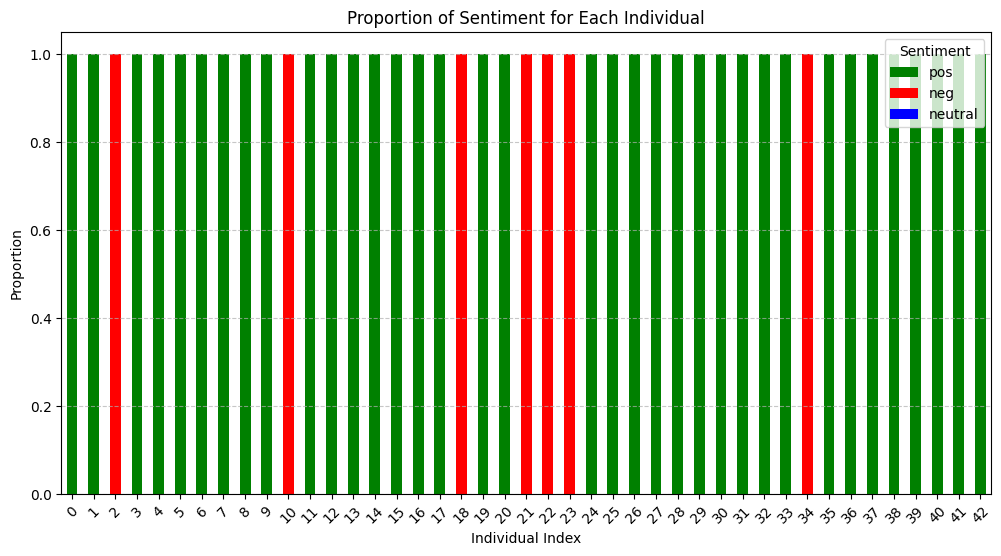

In [ ]:
# เตรียมข้อมูลเฉพาะ 'cap_reason'
cap_reason_data = responses[['cap_reason']].dropna()

# ฟังก์ชันแบ่งคำ
def tokenize_text(text):
    tokens = word_tokenize(text, keep_whitespace=False)
    return tokens

# แบ่งคำใน 'cap_reason' และสร้างตารางคำ
cap_reason_data['tokens'] = cap_reason_data['cap_reason'].apply(tokenize_text)
cap_reason_tokens = cap_reason_data.explode('tokens').reset_index(drop=True)
cap_reason_tokens['word'] = cap_reason_tokens['tokens'].str.strip().str.lower()

# จับคู่คำกับ sentiment lexicon
cap_reason_sentiment = cap_reason_tokens.merge(thai_lexicon, left_on='word', right_on='word', how='inner')

# เพิ่มคอลัมน์ index เพื่อใช้ในการจัดกลุ่มตามแต่ละบุคคล
cap_reason_sentiment['index'] = cap_reason_sentiment.index

# คำนวณ Sentiment สำหรับแต่ละบุคคล
individual_sentiment = cap_reason_sentiment.groupby(['index', 'sentiment']).size().reset_index(name='count')

# Pivot Table เพื่อดู Sentiment ของแต่ละบุคคล
individual_pivot = individual_sentiment.pivot(index='index', columns='sentiment', values='count').fillna(0)
individual_pivot['total'] = individual_pivot.sum(axis=1)  # รวมจำนวนคำทั้งหมดต่อบุคคล
individual_pivot_prop = individual_pivot.div(individual_pivot['total'], axis=0)  # คำนวณสัดส่วน
individual_pivot_prop = individual_pivot_prop.drop(columns='total')  # ลบคอลัมน์ total

# แสดงผลลัพธ์สัดส่วน Sentiment สำหรับแต่ละบุคคล
print("สัดส่วน Sentiment Analysis สำหรับแต่ละบุคคล:")
print(individual_pivot_prop)

# Ensure all sentiment columns ('pos', 'neg', 'neutral') are present
for sentiment in ['pos', 'neg', 'neutral']:
    if sentiment not in individual_pivot_prop.columns:
        individual_pivot_prop[sentiment] = 0  # Add missing sentiment column with 0 values

# Reorder the columns to ensure consistent plotting
individual_pivot_prop = individual_pivot_prop[['pos', 'neg', 'neutral']]

# Plot the stacked bar chart
individual_pivot_prop.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color={'neg': 'red', 'pos': 'green', 'neutral': 'blue'}
)

# Add labels and title
plt.title("Proportion of Sentiment for Each Individual")
plt.xlabel("Individual Index")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# Check and convert all columns in individual_pivot_prop to numeric (if necessary)
for col in individual_pivot_prop.columns:
    individual_pivot_prop[col] = pd.to_numeric(individual_pivot_prop[col], errors='coerce')

# Assign the dominant sentiment for each individual to the responses DataFrame
responses['sentiment'] = individual_pivot_prop.idxmax(axis=1).reset_index(drop=True)

# Display the updated DataFrame with the new sentiment column
print(responses[['cap_reason', 'sentiment']])

                                          cap_reason sentiment
0  เพราะรู้สึกว่าตัวเองสามารถขวนขวายหาความรู้ใหม่...       pos
1                  สามารถสอนในเนื้อหาที่รับผิดชอบได้       pos
2                 บางงานก็ทำได้ดี บางงานก็ทำไปแบบงงๆ       neg
3  มีความรู้ ทักษะในวิชาเอกที่สามารถถ่ายทอดและพัฒ...       pos
4  เป็นวิชาชีพที่ชอบ เรื่องภาระงานใช้การบริหารจัด...       pos
                                           cap_reason sentiment
0   เพราะรู้สึกว่าตัวเองสามารถขวนขวายหาความรู้ใหม่...       pos
1                   สามารถสอนในเนื้อหาที่รับผิดชอบได้       pos
2                  บางงานก็ทำได้ดี บางงานก็ทำไปแบบงงๆ       neg
3   มีความรู้ ทักษะในวิชาเอกที่สามารถถ่ายทอดและพัฒ...       pos
4   เป็นวิชาชีพที่ชอบ เรื่องภาระงานใช้การบริหารจัด...       pos
5                                 ชอบในการสินนักเรียน       pos
6   ค่าใช้จ่ายส่วนที่ออกให้นักเรียนเอง มีส่วนทำให้...       pos
7   สามารถถ่ายทอดความรู้ได้ดี แต่ก็ยังมีเนื้อหาบาง...       pos
8         ได้รับการเรียน,ฝึก,อบรมตลอดระยะเวลาก

**this** **code** สร้าง sentiment จาก scale ที่ตอบ 1-2 neg 3-4 pos

In [ ]:
# Import necessary libraries
import pandas as pd
from pythainlp.tokenize import word_tokenize
import matplotlib.pyplot as plt


In [ ]:
# Load dataset
responses_file = "/content/drive/MyDrive/วิทยานิพนธ์-พีรยา/practice/ตอบกลับ-แบบสอบถามสุขภาวะด้านอาชีพของครู.xlsx"
responses = pd.read_excel(responses_file)

# Display column names to confirm structure
print("Dataset Columns:", responses.columns)

Dataset Columns: Index(['ประทับเวลา', 'current_teach', 'age', 'teach_years', 'emp_status',
       'school_aff', 'school_size', 'school_ctx', 'job_pos', 'add_resp',
       'teach_level', 'teach_hours', 'salary', 'self_cap', 'cap_reason', ' ',
       'skill_dev', 'job_happy', 'happy_reason', 'happy_source', 'career_goal',
       'stress_lvl', 'stress_impact', 'stress_mgt', 'dir_relation', 'dir_view',
       'col_relation', 'col_relation.1', 'std_relation', 'std_view',
       'add_comment'],
      dtype='object')


In [ ]:
# Define a function to map self_cap values to sentiment labels
def label_sentiment_from_self_cap(self_cap_value):
    if self_cap_value in [1, 2]:
        return 'negative'
    elif self_cap_value in [3, 4]:
        return 'positive'
    else:
        return 'neutral'  # Optional for undefined values

# Apply the function to create the sentiment column
responses['sentiment'] = responses['self_cap'].apply(label_sentiment_from_self_cap)

# Display the updated DataFrame
print("Updated Data with Sentiment Labels:")
print(responses[['self_cap', 'cap_reason', 'sentiment']].head())

Updated Data with Sentiment Labels:
   self_cap                                         cap_reason sentiment
0         4  เพราะรู้สึกว่าตัวเองสามารถขวนขวายหาความรู้ใหม่...  positive
1         4                  สามารถสอนในเนื้อหาที่รับผิดชอบได้  positive
2         3                 บางงานก็ทำได้ดี บางงานก็ทำไปแบบงงๆ  positive
3         4  มีความรู้ ทักษะในวิชาเอกที่สามารถถ่ายทอดและพัฒ...  positive
4         4  เป็นวิชาชีพที่ชอบ เรื่องภาระงานใช้การบริหารจัด...  positive



Sentiment Counts:
sentiment
positive    48
negative     5
Name: count, dtype: int64


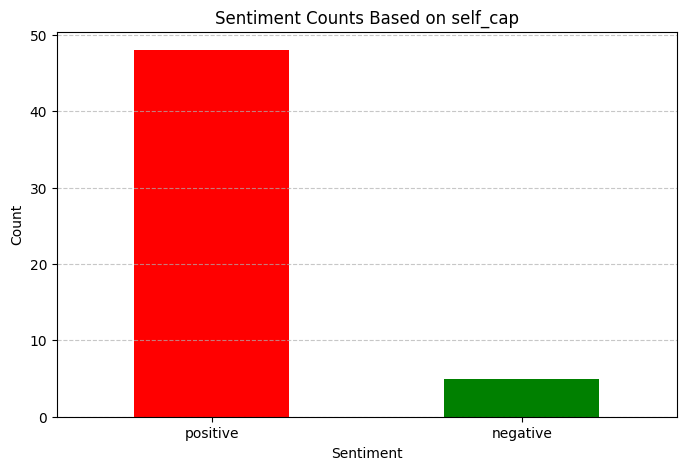

In [ ]:
# Count the number of each sentiment
sentiment_counts = responses['sentiment'].value_counts()

# Display sentiment counts
print("\nSentiment Counts:")
print(sentiment_counts)

# Plot the sentiment counts
sentiment_counts.plot(kind='bar', color=['red', 'green', 'blue'], figsize=(8, 5))
plt.title("Sentiment Counts Based on self_cap")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [4]:
# Tokenize the cap_reason column
def tokenize_text(text):
    tokens = word_tokenize(text, keep_whitespace=False)
    return tokens

# Apply tokenization to cap_reason
responses['cap_reason_tokens'] = responses['cap_reason'].fillna('').apply(tokenize_text)

# Display a sample of tokenized text
print("\nSample Tokenized Text:")
print(responses[['cap_reason', 'cap_reason_tokens']].head())

NameError: name 'responses' is not defined

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to save the file in Google Drive
updated_file = '/content/drive/MyDrive/วิทยานิพนธ์-พีรยา/practice/updated_responses_with_sentiment.xlsx'

# Save the updated responses DataFrame to the specified path
responses.to_excel(updated_file, index=False)
print(f"\nUpdated data saved to {updated_file}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Updated data saved to /content/drive/MyDrive/วิทยานิพนธ์-พีรยา/practice/updated_responses_with_sentiment.xlsx


sentiment group by teach_exp

<ipython-input-31-1fad97d4bec7>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sentiment_grouped = responses.groupby(['teach_years_group', 'sentiment']).size().reset_index(name='count')


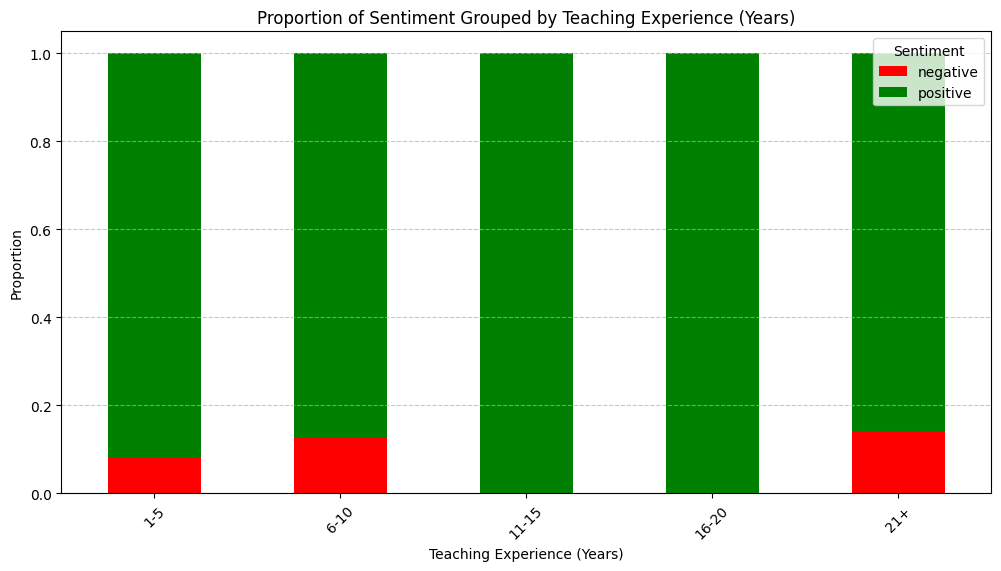

In [ ]:
# Step 1: Group `teach_years` into Categories
# Define bins and labels for grouping
bins = [0, 5, 10, 15,20, float('inf')]
labels = ['1-5', '6-10', '11-15', '16-20','21+']

# Create a new column for grouped teach_years
responses['teach_years_group'] = pd.cut(responses['teach_years'], bins=bins, labels=labels)

# Step 2: Group by `teach_years_group` and `sentiment` and Count Occurrences
sentiment_grouped = responses.groupby(['teach_years_group', 'sentiment']).size().reset_index(name='count')

# Pivot to Calculate Proportions
sentiment_pivot = sentiment_grouped.pivot(index='teach_years_group', columns='sentiment', values='count').fillna(0)
sentiment_pivot['total'] = sentiment_pivot.sum(axis=1)  # Total per teach_years_group
sentiment_pivot_prop = sentiment_pivot.div(sentiment_pivot['total'], axis=0).drop(columns='total')  # Proportions

# Step 3: Plot Proportions
# Define colors for sentiments
color_map = {'positive': 'green', 'negative': 'red', 'neutral': 'blue'}

# Create a stacked bar chart
sentiment_pivot_prop.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=[color_map[col] for col in sentiment_pivot_prop.columns]
)

# Add Titles and Labels
plt.title("Proportion of Sentiment Grouped by Teaching Experience (Years)")
plt.xlabel("Teaching Experience (Years)")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.legend(title="Sentiment", labels=sentiment_pivot_prop.columns)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the Plot
plt.show()


In [ ]:
# Count the number of individuals in each teaching experience group
group_counts = responses['teach_years_group'].value_counts().sort_index()

# Display the counts
print("Number of Individuals in Each Teaching Experience Group:")
print(group_counts)


Number of Individuals in Each Teaching Experience Group:
teach_years_group
1-5      24
6-10     16
11-15     3
16-20     3
21+       7
Name: count, dtype: int64


NaiveBayes

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Ensure required columns exist
if 'cap_reason' not in responses.columns or 'sentiment' not in responses.columns:
    raise KeyError("Required columns 'cap_reason' or 'sentiment' not found in the dataset.")

# Prepare features (X) and target labels (y)
X = responses['cap_reason'].fillna('')  # Text data
y = responses['sentiment']             # Sentiment labels

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Vectorize text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=500)  # Limit to top 500 features
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Train Naïve Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

nb_model2 = MultinomialNB(alpha=0.5)
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Predict sentiment for test data
y_pred = nb_model.predict(X_test_tfidf)

# Display evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         2
    positive       0.82      1.00      0.90         9

    accuracy                           0.82        11
   macro avg       0.41      0.50      0.45        11
weighted avg       0.67      0.82      0.74        11

Accuracy: 0.8181818181818182


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Define parameter grid for alpha
param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}

# Initialize the MultinomialNB model
nb_model = MultinomialNB()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model with GridSearch
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best hyperparameters:", best_params)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test_tfidf)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best hyperparameters: {'alpha': 0.5}

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         2
    positive       0.82      1.00      0.90         9

    accuracy                           0.82        11
   macro avg       0.41      0.50      0.45        11
weighted avg       0.67      0.82      0.74        11



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
results_df = pd.DataFrame({
    'Actual': y_test,          # True labels
    'Predicted': y_pred        # Predicted labels from the model
}).reset_index(drop=True)

print(results_df.head())

     Actual Predicted
0  negative  positive
1  positive  positive
2  positive  positive
3  positive  positive
4  positive  positive


All accuracy results from GridSearchCV:
   Alpha  Mean Accuracy
1    0.5       0.930556
2    1.0       0.930556
3    1.5       0.930556
4    2.0       0.930556
0    0.1       0.738889


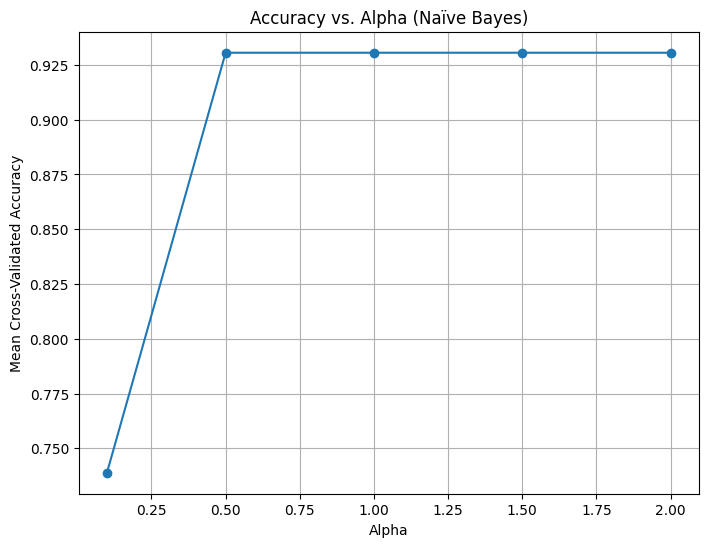

In [ ]:
results = grid_search.cv_results_

alphas = results['param_alpha']
mean_accuracies = results['mean_test_score']

accuracy_df = pd.DataFrame({'Alpha': alphas, 'Mean Accuracy': mean_accuracies})

print("All accuracy results from GridSearchCV:")
print(accuracy_df.sort_values(by='Mean Accuracy', ascending=False))

# Visualize the results
plt.figure(figsize=(8, 6))
plt.plot(alphas, mean_accuracies, marker='o', linestyle='-')
plt.title("Accuracy vs. Alpha (Naïve Bayes)")
plt.xlabel("Alpha")
plt.ylabel("Mean Cross-Validated Accuracy")
plt.grid(True)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
print(responses.head())

topic modeling

word cloud cap_reason

In [5]:
import pandas as pd
from pythainlp.corpus.common import thai_stopwords
from pythainlp.tokenize import word_tokenize

# Reload the dataset
file_path = 'updated_responses_with_sentiment.xlsx'  # Specify the correct path
responses = pd.read_excel("/content/drive/MyDrive/วิทยานิพนธ์-พีรยา/practice/updated_responses_with_sentiment.xlsx")

# Define a function to preprocess tokens
def preprocess_tokens(tokens):
    stopwords = set(thai_stopwords())  # Load Thai stopwords
    custom_stopwords = set(["การ", "งาน", "ที่", "ใน", "และ"])  # Add custom stopwords
    stopwords.update(custom_stopwords)

    # Remove stopwords and single characters (except vowels and tonal marks)
    filtered_tokens = [token for token in tokens if token not in stopwords and (len(token) > 1 or token in '่้๊๋ิีุูั็์')]
    return filtered_tokens

# Tokenize and preprocess the 'cap_reason' column
responses['cap_reason_tokens'] = responses['cap_reason'].fillna('').apply(lambda x: word_tokenize(x, keep_whitespace=False))
responses['filtered_tokens'] = responses['cap_reason_tokens'].apply(preprocess_tokens)

# Display the original and filtered tokens for the first 10 rows
filtered_tokens_sample = responses[['cap_reason', 'cap_reason_tokens', 'filtered_tokens']].head(10)
print(filtered_tokens_sample)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/วิทยานิพนธ์-พีรยา/practice/updated_responses_with_sentiment.xlsx'

In [ ]:
from google.colab import files

# Upload the Thai font file
uploaded = files.upload()


Saving THSarabunNew.ttf to THSarabunNew (1).ttf


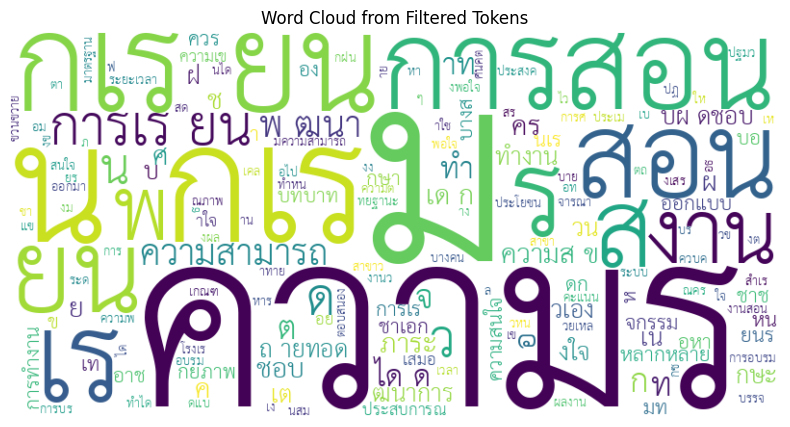

In [ ]:
thai_font_path = list(uploaded.keys())[0]  # Get the uploaded font file path

# Generate the word cloud with the uploaded font
wordcloud = WordCloud(
    font_path=thai_font_path,
    width=800,
    height=400,
    background_color='white'
).generate(filtered_tokens_combined)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud from Filtered Tokens")
plt.show()


In [3]:
print(filtered_tokens_combined)

NameError: name 'filtered_tokens_combined' is not defined

LSTM

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Ensure the required columns exist
if 'cap_reason' not in responses.columns or 'sentiment' not in responses.columns:
    raise KeyError("Required columns 'cap_reason' or 'sentiment' not found in the dataset.")

# Prepare text (X) and target labels (y)
X = responses['cap_reason'].fillna('')  # Text data
y = pd.get_dummies(responses['sentiment']).values  # One-hot encode sentiment labels

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Initialize the tokenizer and fit it on the text data
tokenizer = Tokenizer(num_words=5000)  # Use the top 5000 most frequent words
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to the same length
max_sequence_length = 100  # Adjust based on your dataset
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_sequence_length),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(64),
    Dropout(0.5),
    Dense(y.shape[1], activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the LSTM model
history = model.fit(
    X_train_padded,
    y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 677ms/step - accuracy: 0.7244 - loss: 0.6831 - val_accuracy: 0.8889 - val_loss: 0.5471
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9388 - loss: 0.5207 - val_accuracy: 0.8889 - val_loss: 0.3991
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9388 - loss: 0.3569 - val_accuracy: 0.8889 - val_loss: 0.3819
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step - accuracy: 0.9388 - loss: 0.2614 - val_accuracy: 0.8889 - val_loss: 0.5154
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step - accuracy: 0.9388 - loss: 0.2882 - val_accuracy: 0.8889 - val_loss: 0.5688


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8182 - loss: 0.9296

LSTM Model Accuracy: 0.8181818127632141


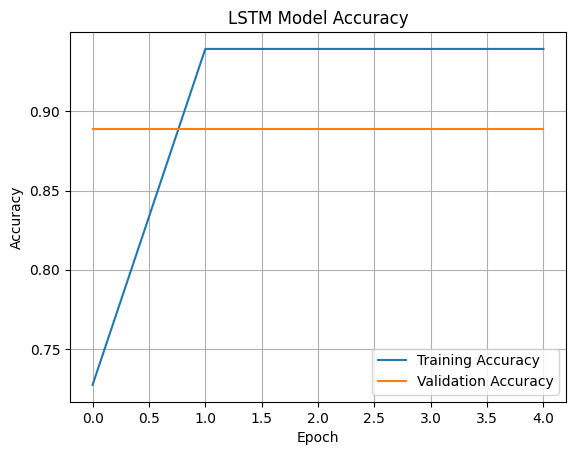

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print("\nLSTM Model Accuracy:", accuracy)

# Plot training and validation accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Predict sentiment for test data
y_pred = model.predict(X_test_padded)
predicted_labels = y_pred.argmax(axis=1)

# Map predictions back to sentiment labels
label_map = {i: label for i, label in enumerate(pd.get_dummies(responses['sentiment']).columns)}
predicted_sentiments = [label_map[label] for label in predicted_labels]

# Display sample predictions
for i in range(5):
    print(f"Text: {X_test.iloc[i]}")
    print(f"Actual Sentiment: {label_map[y_test.argmax(axis=1)[i]]}")
    print(f"Predicted Sentiment: {predicted_sentiments[i]}")
    print("----")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
Text: ครูมีภาระความรับผิดชอบบทบาทหน้าที่ที่มากมายหลากหลาย ทำให้ไม่สามารถทำงานได้อย่างเต็มที่เต็มความสามารถ จึงส่งผลให้รู้สึกไม่มีความสามารถเพียงพอในการเป็นครูในปัจจุบัน
Actual Sentiment: negative
Predicted Sentiment: positive
----
Text: ชอบ
Actual Sentiment: positive
Predicted Sentiment: positive
----
Text: -
Actual Sentiment: positive
Predicted Sentiment: positive
----
Text: สามารถทำการสอนได้ แต่ภาระงานอื่นๆที่นอกเหนือจากการสอนในโรงเรียน อาจไม่มีความสามารถมากเกินพอ ทำได้ไม่ดีเท่าที่ควร
Actual Sentiment: positive
Predicted Sentiment: positive
----
Text: -
Actual Sentiment: positive
Predicted Sentiment: positive
----
